Talk about random forest and how it works. Write specific context about its use cases here with this data.

In [2]:
# Import libraries and data

import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
# Define function for model comparison

def collect_metrics(y_true, y_pred, method_name):
    return {
        'method': method_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

In [5]:
# Prepare data

# Seperate into target and predictors
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

# Identify column types
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing and model pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=49))),
    ('classifier', RandomForestClassifier(random_state=49))
])

Write about model hyperparameters, why they are important and how grid search can be used to optimize model fitting.

In [ ]:
# Perform grid search for optimal hyperparameters and update classifier pipeline

# Define hyperparameter grid
param_grid = {
    'feature_selection__estimator__n_estimators': [100],
    'feature_selection__threshold': ['mean', 'median', 0.01],
    'classifier__n_estimators': list(range(25, 200, 25)),
    'classifier__max_depth': [None] + list(range(5, 20, 5)),
    'classifier__min_samples_split': list(range(2, 10)),
    'classifier__min_samples_leaf': list(range(1, 15, 2)),
    'classifier__max_features': ['sqrt', 'log2']
}

# Define GridSearchCV parameters
grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,  # Use all processor cores to speed up grid search
    verbose=1
)

# Fit the grid search
grid_search.fit(X, y)

# Print the results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Update parameters for subsequent model evaluation
best_clf = grid_search.best_estimator_
clf = best_clf

Fitting 5 folds for each of 9408 candidates, totalling 47040 fits


Feature Importances:
Gender: 0.2771
BMI: 0.2529
Age: 0.2176
Ethnicity: 0.1500
EducationLevel: 0.1023


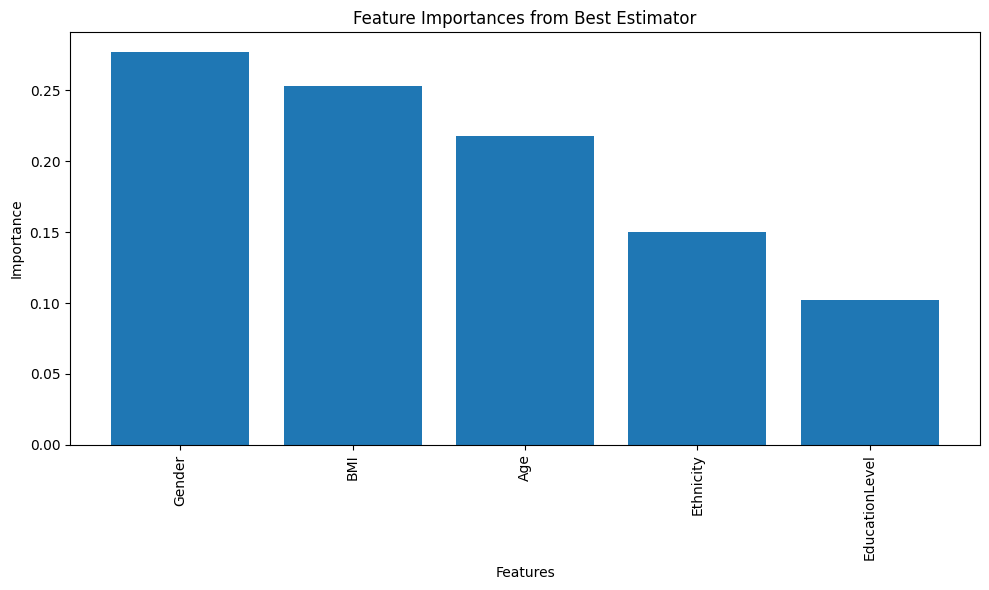

In [23]:
# Extract the classifier from the pipeline.
rf_classifier = clf.named_steps['classifier']

# Retrieve the feature importances from the Random Forest model.
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature importances by sorting them in descending order.
print("Feature Importances:")
for idx in indices:
    print(f"{X.columns[idx]}: {importances[idx]:.4f}")

# Visualize the feature importances using a bar chart.
plt.figure(figsize=(10, 6))
plt.title("Feature Importances from Best Estimator")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Talk about cross validation methods and standard test train split and why we use it.

In [24]:
# Fit random forest model using optimized hyperparameters and test/train split

metrics_list = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

metrics_list.append(collect_metrics(y_test, y_pred, method_name='Train/Test Split'))

Talk about k fold cross validation, why we use it and why we settled on 10 folds here.

In [25]:
# K-Fold

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=49)
y_true_kf = []
y_pred_kf = []

for train_idx, test_idx in kfold.split(X, y):
    clf.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = clf.predict(X.iloc[test_idx])
    y_true_kf.extend(y.iloc[test_idx])
    y_pred_kf.extend(pred)

metrics_list.append(collect_metrics(y_true_kf, y_pred_kf, method_name='Stratified K-Fold'))

Talk about leave one out cross validation and make sure to highlight computational inefficiency.

In the final latex document we will need to make sure we use this data to compare model fits using various methods. Also talk about these metrics and why they matter, plus why we didn't use something else such as AUC-ROC.

In [ ]:
# Compare results of model fitting

results_df = pd.DataFrame(metrics_list)
print(results_df)

              method  accuracy  precision    recall  f1_score
0   Train/Test Split  0.969767   0.942675  0.973684  0.957929
1  Stratified K-Fold  0.953467   0.950820  0.915789  0.932976


Summary, even though there is essentially no performance difference between cross validation types here we should use k-fold CV as the preffered method as it is expected to perform better than a standard test-train split on larger and more complex datasets and LOOCV is far too computationally expensive to scale well to other data.

                   Accuracy  Precision    Recall  F1 Score   ROC AUC
Stratified K-Fold  0.953467    0.95082  0.915789  0.932976  0.948398


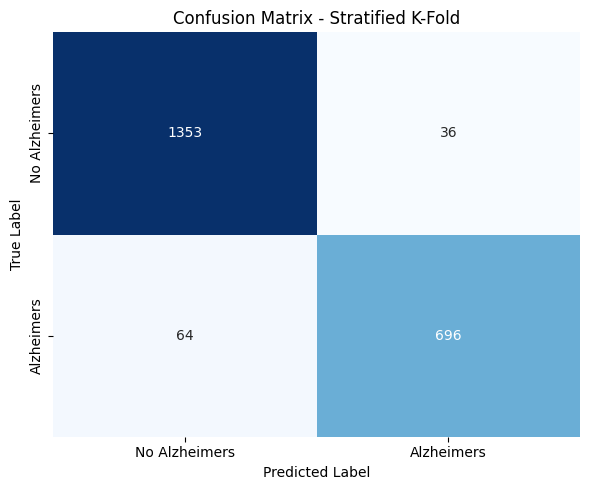

In [29]:
# Define your Stratified K-Fold object
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=49)

# Initialize lists to store the aggregated true labels, predictions, and probabilities
y_true_kf = []
y_pred_kf = []
y_proba_kf = []

# Loop over each fold in the cross-validation
for train_idx, test_idx in kfold.split(X, y):
    # Train the classifier on the training split for the current fold
    clf.fit(X.iloc[train_idx], y.iloc[train_idx])
    
    # Predict labels and probabilities on the test split of the current fold
    pred = clf.predict(X.iloc[test_idx])
    proba = clf.predict_proba(X.iloc[test_idx])[:, 1]  # probability values for ROC AUC
    
    # Aggregate the true labels, predicted labels, and probabilities
    y_true_kf.extend(y.iloc[test_idx])
    y_pred_kf.extend(pred)
    y_proba_kf.extend(proba)

# Compute the performance metrics using aggregated results
metrics = {
    'Accuracy': accuracy_score(y_true_kf, y_pred_kf),
    'Precision': precision_score(y_true_kf, y_pred_kf),
    'Recall': recall_score(y_true_kf, y_pred_kf),
    'F1 Score': f1_score(y_true_kf, y_pred_kf),
    'ROC AUC': roc_auc_score(y_true_kf, y_proba_kf)
}

# Convert metrics dictionary to a DataFrame for a nice display
metrics_df = pd.DataFrame(metrics, index=['Stratified K-Fold'])
print(metrics_df)

# Compute the confusion matrix using the aggregated predictions
cm = confusion_matrix(y_true_kf, y_pred_kf)
labels = ['No Alzheimers', 'Alzheimers']

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Stratified K-Fold')
plt.tight_layout()
plt.show()